# Analysis of clusters in BacSC

To perform differential expression analysis, we use a modified version of the ClusterDE approach (Song et al., 2023). For this, we will first generate a synthetic null dataset, and then perform FDR control on the p-values of a Wilcoxon ranksum test.

This tutorial covers testing each cluster against the union of all other clusters. For testing just two clusters against each other, subset the data to the clusters of interest immediately at the beginning and remove all genes that are not expressed in any of the two clusters. Then apply the rest of the pipeline as shown here

In [1]:
# These imports and path modifications are only necessary for development
import importlib

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau


    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import warnings
warnings.filterwarnings("ignore")


## Read data from main pipeline


In [3]:
# Adjust the data path and filename based on your folder structure
data_path = "../data/probe_Bac_scRNAseq_Rosenthal/B subtilis minimal media"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")


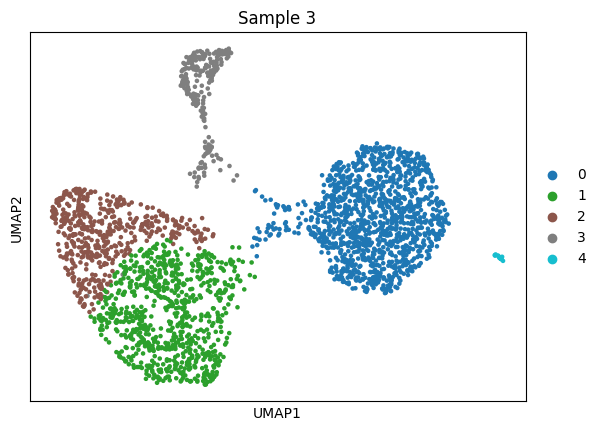

In [4]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution family and parameters for every gene

Depending on the size of your data, this step might take a while, but is strictly necessary

In [5]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB withou

### Find optimal correlation matrix scaling

This step can be skipped if a slightly suboptimal null data is sufficient. To speed up the tutorial, the calculated scaling factor and correlation matrix are given below (commented out)

In [6]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 61.062145526926074
Factor: 2 - Error: 41.61230366138131
Factor: 3.6180339999999998 - Error: 47.5639997000499
Factor: 2 - Error: 41.61230366138131
Factor: 2.61803399102434 - Error: 42.6728986049149
Factor: 1.61803399 - Error: 41.928476205147085
Factor: 2.236067977595943 - Error: 41.5709760988543
Factor: 2.3819660117007944 - Error: 42.03119452115826
Factor: 2.1458980341048512 - Error: 41.553153060038696
Factor: 2.0901699441509773 - Error: 41.50337615883041
Factor: 2.055728090361706 - Error: 41.58788587302456
Factor: 2.11145618031558 - Error: 41.759568018114386
Factor: 2.077014326682086 - Error: 41.63394466492494
Factor: 2.0983005628466884 - Error: 41.846903049848464
Factor: 2.085144945437299 - Error: 41.685404726106
Factor: 2.0932755641330094 - Error: 41.53792009143197
Factor: 2.0882505654420584 - Error: 41.40961663161148
Factor: 2.087064324160264 - Error: 41.461600318279295
Factor: 2.088983702869183 - Error: 41.479646030872075
Factor: 2.0877974615927544 - Error: 41.53

In [7]:
# Use this if the previous code cell was skipped
# xmin = 2.088637562328564
# _, R_est_noscale = cd.generate_nb_data_copula(data_gene_01, rng_seed=3456, nb_flavor="statsmod_auto",
#                                                   auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
#                                                   R_est=None, check_pd=True)

In [8]:
importlib.reload(cd)

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


### Generate synthetic null data

In [9]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [10]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [11]:
# Filter out genes in the original data that were sampled as all zeros in the null data 
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

### Diagnostic plots

The marginal distributions of gene mean and variance should be almost the same, and gene means and variances should als correspond to the original data

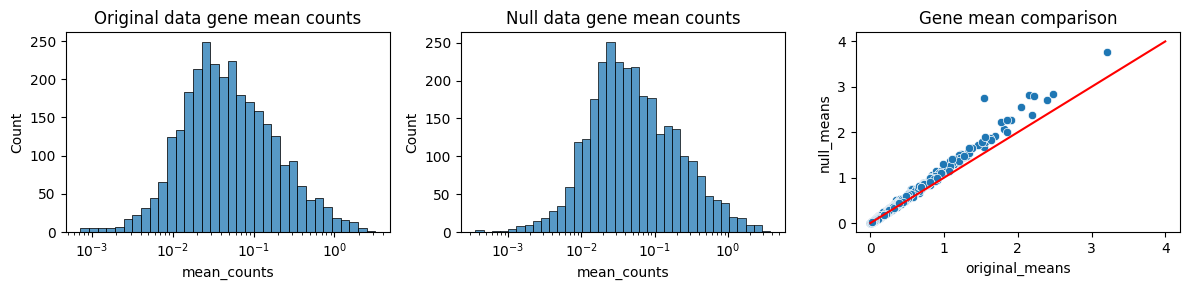

Spearman correlation: 0.9974085258623435


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(f'Spearman correlation: {spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]).statistic}')

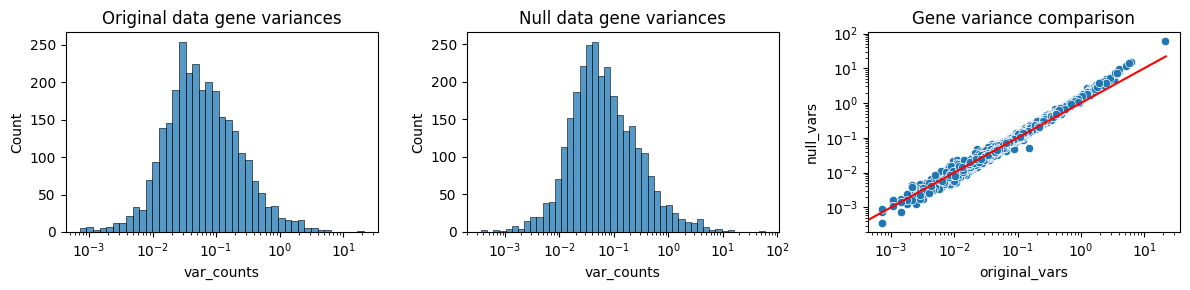

Spearman correlation: 0.9945072531930294


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(f'Spearman correlation: {spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]).statistic}')


Gene-gene correlations - larger correlations should approximately follow the red line

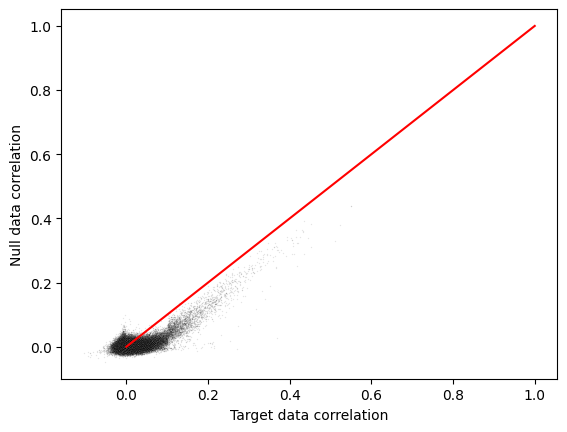

In [14]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process synthetic null data

We apply the same data processing to the synthetic null data as we did to the original data (VST, PCA, UMAP)

In [15]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [16]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", seed=1234)
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


The synthetic null data should have an undefined shape ("blob") that shows no clear clusters

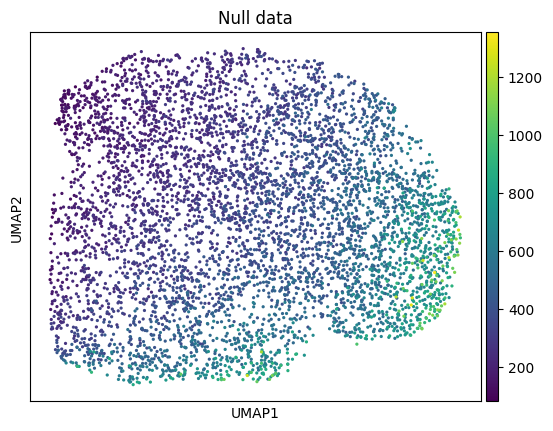

In [31]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


**Checkpoint** 

Save the data to disk and read it again

In [18]:
data_null_gen.write(data_path + "/null_data_opt_tutorial.h5ad")

In [19]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_opt_tutorial.h5ad")
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

## Differential expression testing

Now we perform the actual DE testing.

### Find a good split for the null data

This is a modification from ClusterDE - we randomly cluster the synthetic data in two halves multiple times and select the clustering that has the largest minimal p-value. This step again takes a moment, but is necessary

In [20]:
n_splits = 1
rng = np.random.default_rng(1234)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    was_greater = False
    max_res_1_cluster = 0.01
    
    while twoclust is False:
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        print(f"resolution: {res2}, clusters: {nclust}")

        if nclust == 2:
            twoclust = True
            break
        elif nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            else: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 5*res_step
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 15)

            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 5*res_step
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}")

resolution: 0.01, clusters: 1
resolution: 0.035, clusters: 1
resolution: 0.06, clusters: 1
resolution: 0.085, clusters: 1
resolution: 0.11, clusters: 2
split 1/1 - Resolution 0.11
Best split: No. 0 - seed: 979 - minimal p-value: 1.1662302933973507e-249


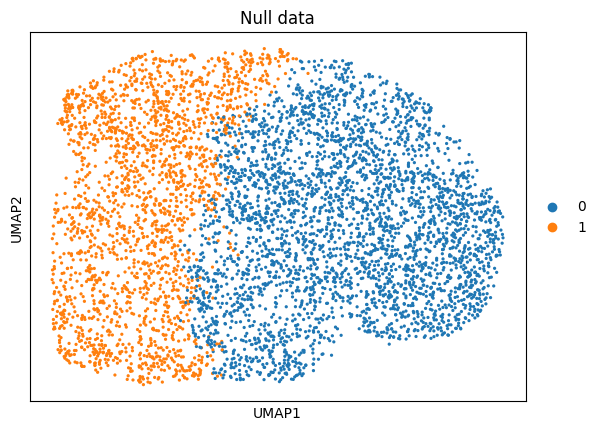

In [21]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [22]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/null_data_opt_tutorial.h5ad")

### DE testing with FDR control

Now we actually do the DE testing for every cluster against the rest of the population. You can adjust the FDR here or subset the respective tables in pvals_log_gen afterwards

In [23]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.06459143968871596
Cluster 2 - DE genes: 0; Minimum q value: 0.2130822596630327
Cluster 3 - DE genes: 48; Minimum q value: 0.020833333333333332
Cluster 1 - DE genes: 0; Minimum q value: 0.26437941473259335
Cluster 4 - DE genes: 54; Minimum q value: 0.027777777777777776


Diagnostic plots - The distribution of contrast scores should have a peak around 0 and should be approx. symmetric

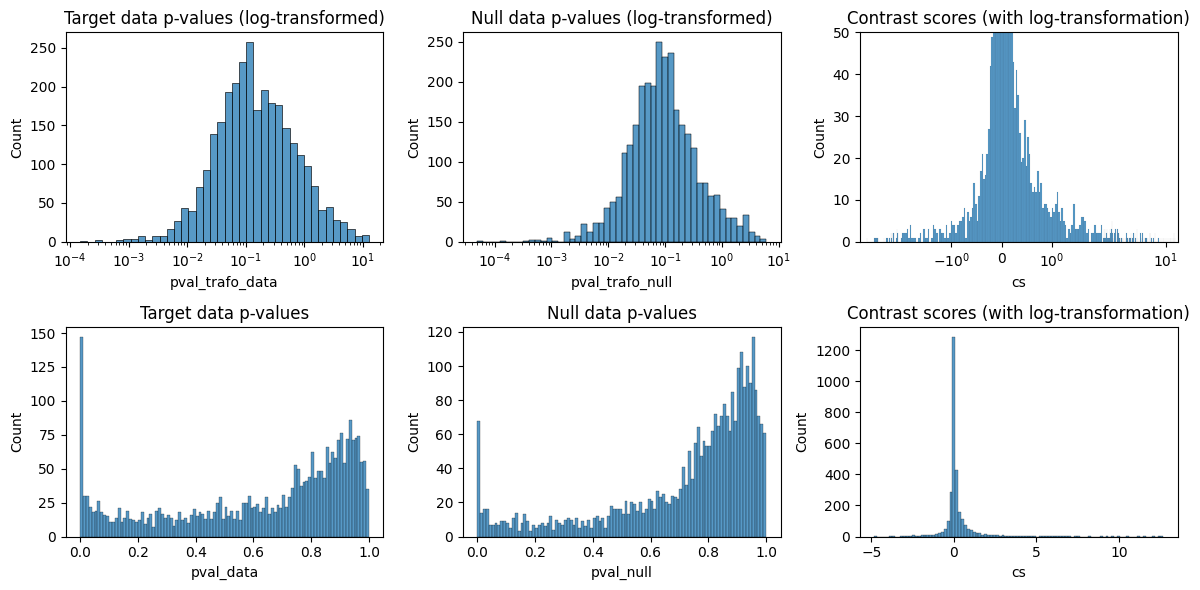

In [24]:
c = "4"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In pvals_log_gen, every cluster has a table that shows pvalues, q-values (which can be thresholded to get gene subsets at certain FDR levels), ... for each gene.

In [25]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
index,,,,,,
groEL,5.875128e-86,4.068796e-01,85.230983,0.390534,84.840449,0.064591
rpsF,2.560384e-86,1.261484e-03,85.591695,2.899118,82.692577,0.064591
ssbA,9.089716e-83,5.297523e-10,82.041450,9.275927,72.765523,0.064591
leuB,2.176039e-106,1.057180e-37,105.662333,36.975851,68.686482,0.064591
thiF,4.083755e-92,6.683894e-28,91.388940,27.174970,64.213970,0.064591
...,...,...,...,...,...,...
rpsC,2.231282e-08,3.087701e-80,7.651446,79.510365,-71.858919,1.000000
rpoA,2.001274e-02,6.323665e-76,1.698693,75.199031,-73.500338,1.000000
fusA,2.740076e-15,4.231790e-90,14.562237,89.373476,-74.811239,1.000000


Attach DE results to the data object and write to disk

In [26]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [27]:
data_gene_nonzero.write(data_path + "/filtered_data_maxpool_processed_tutorial_cluster.h5ad")

## DE plots, ...

Here, we find some examples for plots that show the DE genes (or top-ranked genes) for every cluster

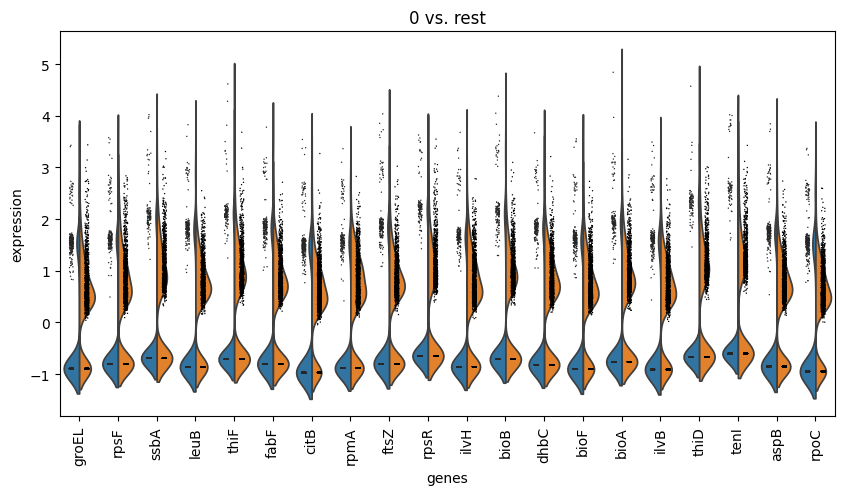

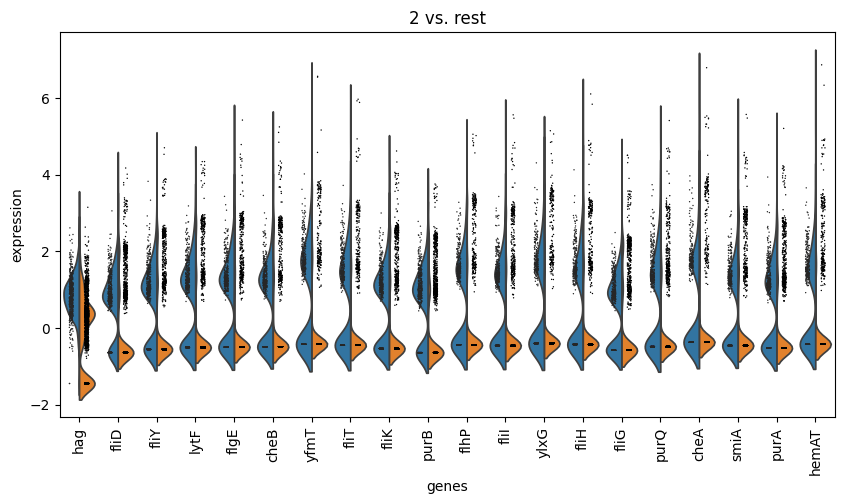

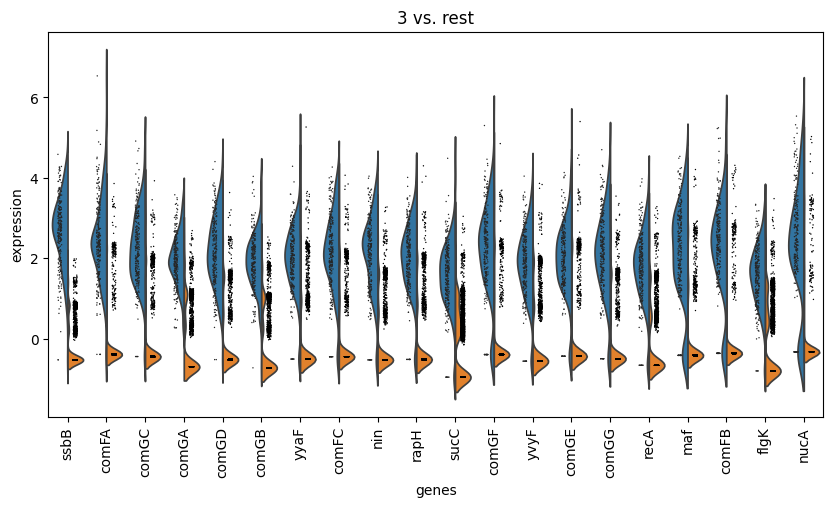

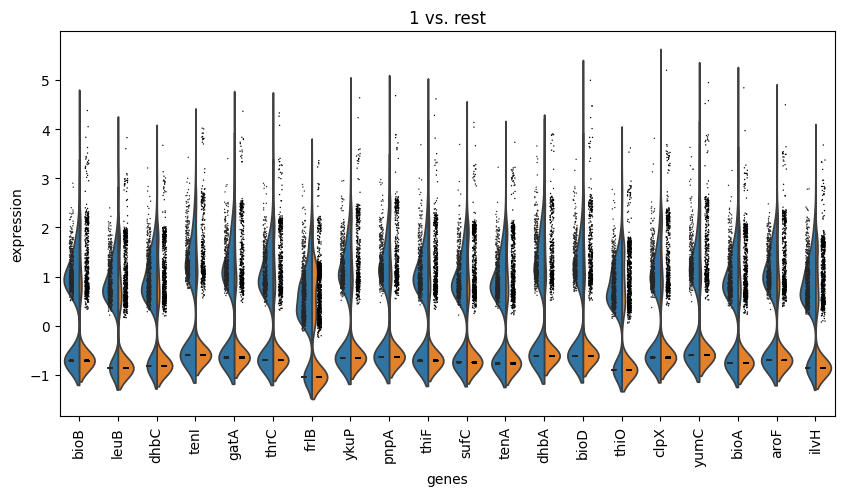

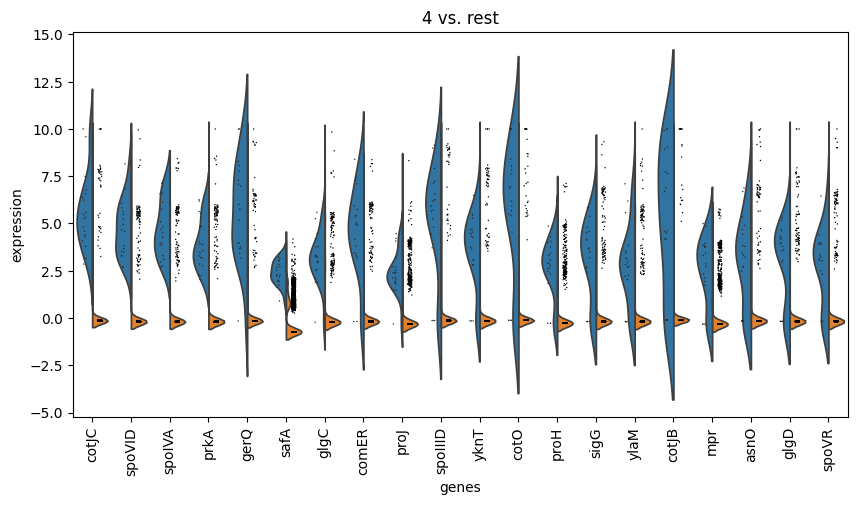

In [28]:
# Plot 20 top-ranked genes (lowest q-values) for each cluster
n_genes = 20
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    with plt.rc_context({"figure.figsize": (10, 5)}):
        sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [29]:
# Show gene name and symbol for top genes per cluster
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["Locus tag", "Name", "Symbol"]])

Cluster 0
      Locus tag                                               Name Symbol
index                                                                    
groEL    PA4385                          molecular chaperone GroEL  groEL
rpsF     PA4935                           30S ribosomal protein S6   rpsF
ssbA        NaN                                                NaN    NaN
leuB     PA3118                    3-isopropylmalate dehydrogenase   leuB
thiF        NaN                                                NaN    NaN
fabF        NaN                                                NaN    NaN
citB        NaN                                                NaN    NaN
rpmA     PA4567                          50S ribosomal protein L27   rpmA
ftsZ     PA4407                         cell division protein FtsZ   ftsZ
rpsR     PA4934                          30S ribosomal protein S18   rpsR
ilvH     PA4695                acetolactate synthase small subunit   ilvH
bioB     PA0500             

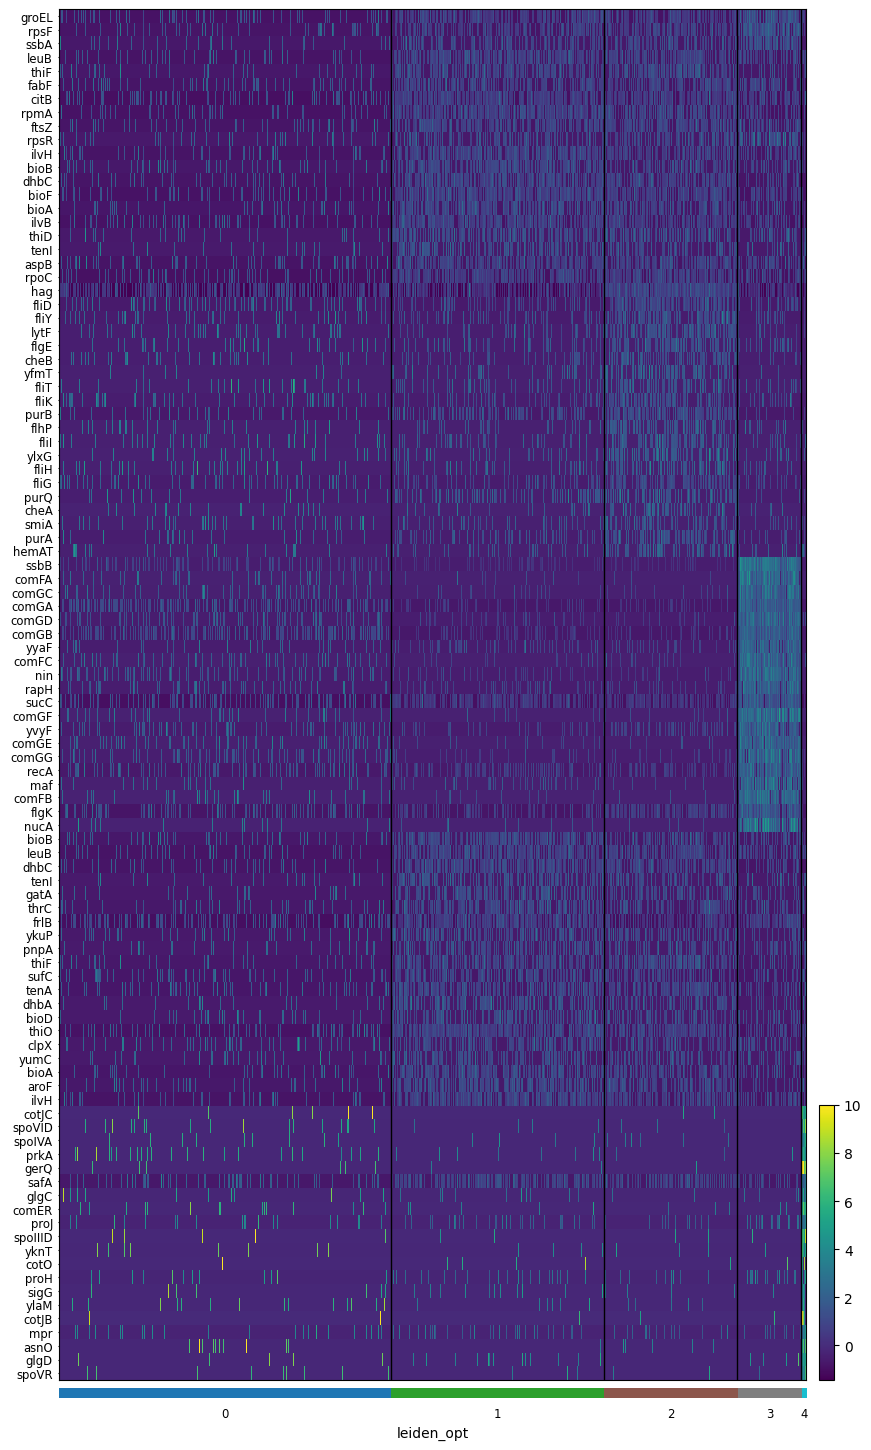

In [30]:
# Heatmap of normalized expression per cluster
sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True, show_gene_labels=True)